In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the Dataset

In [ ]:
directory= "/content/drive/MyDrive/pcod/train"

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
import numpy as np
import os
import pandas as pd

In [ ]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=24,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=True,
    crop_to_aspect_ratio=False,
)

Found 1944 files belonging to 2 classes.


Visualization

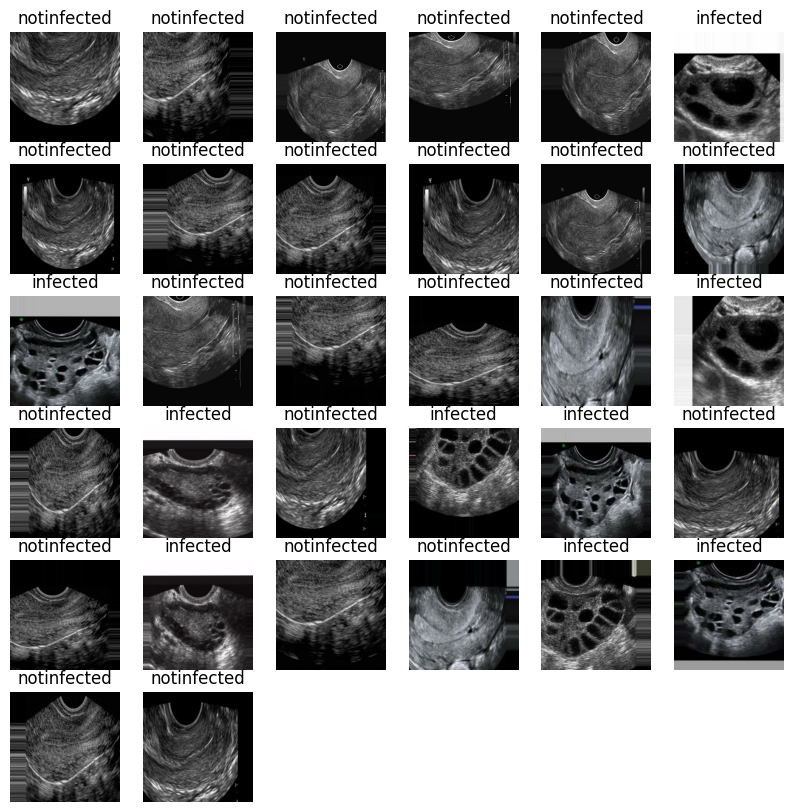

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(2):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create generator
datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=30,
                             validation_split=0.3,
                             fill_mode='nearest'
                             )
# prepare an iterators for each dataset
train_it = datagen.flow_from_directory( directory, 
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size=100,
                                       subset='training',
                                       seed=24)
# prepare an iterators for each dataset
val_it = datagen.flow_from_directory( directory, 
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size=100,
                                       subset='validation',
                                       seed=24)

Found 1362 images belonging to 2 classes.
Found 582 images belonging to 2 classes.


In [ ]:
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchy.shape, batchy.min(), batchy.max()))
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(100, 2), min=0.000, max=1.000
Batch shape=(100, 224, 224, 3), min=0.000, max=1.000


Model Building - CNN

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import Sequential

In [ ]:
model1 = Sequential()
model1.add(Conv2D(10, (5,5),padding='valid',activation='relu',input_shape=(224,224,3)))
model1.add(MaxPooling2D(pool_size=(4,4)))
# REPEAT CONV AND POOLING layer 3 TIMES
model1.add(Conv2D(12, (5,5),padding='valid',activation='relu'))
model1.add(MaxPooling2D(pool_size=(4,4)))
#model1.add(Conv2D(128, (5,5),padding='valid',activation='relu'))
# model1.add(Conv2D(256, (5,5),padding='valid',activation='relu'))
# model1.add(MaxPooling2D(pool_size=(4,4)))
model1.add(Flatten())
#model1.add(Dense(128,activation='relu'))
#model1.add(Dense(64,activation='relu'))
model1.add(Dense(2,activation='softmax'))

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
model1.compile(
  optimizer='adam',
  loss=CategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
history = model1.fit( 
  train_it,
  validation_data=val_it,
  epochs=5)

Epoch 1/5
14/14 [==============================] - 273s 20s/step - loss: 0.5660 - accuracy: 0.7761 - val_loss: 0.3965 - val_accuracy: 0.8505
Epoch 2/5
14/14 [==============================] - 96s 7s/step - loss: 0.3238 - accuracy: 0.8693 - val_loss: 0.2478 - val_accuracy: 0.8969
Epoch 3/5
14/14 [==============================] - 107s 8s/step - loss: 0.2525 - accuracy: 0.8847 - val_loss: 0.1542 - val_accuracy: 0.9433
Epoch 4/5
14/14 [==============================] - 107s 8s/step - loss: 0.1643 - accuracy: 0.9361 - val_loss: 0.1289 - val_accuracy: 0.9519
Epoch 5/5
14/14 [==============================] - 96s 7s/step - loss: 0.1097 - accuracy: 0.9633 - val_loss: 0.0865 - val_accuracy: 0.9777


MobileNet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten,Dense
from keras.models import Model,load_model
from keras.applications.mobilenet import MobileNet
import keras
     

base_model = MobileNet(input_shape=(224,224,3),include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = False
     

x= Flatten()(base_model.output)
x= Dense(units=1,activation='sigmoid')(x)
     

model = Model(base_model.input,x)
     

model.compile(optimizer='adam',loss=keras.losses.binary_crossentropy,metrics=['accuracy'])
     

from keras.callbacks import ModelCheckpoint,EarlyStopping

mc = ModelCheckpoint(filepath="bestmodel.h5",monitor='val_accuracy',verbose=1,save_best_only=True)

#Early check points
es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=5,verbose=1)

cb = [mc,es]
     

In [ ]:
hist = model.fit(train_it,
                           steps_per_epoch=10,
                           epochs=10,
                           validation_data=val_it,
                           validation_steps=16,
                          callbacks=cb)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 2.9671 - accuracy: 0.5000 


Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to bestmodel.h5
10/10 [==============================] - 299s 32s/step - loss: 2.9671 - accuracy: 0.5000 - val_loss: 1.6608 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.9107 - accuracy: 0.5000

10/10 [==============================] - 76s 7s/step - loss: 1.9107 - accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 1.3402 - accuracy: 0.5000

10/10 [==============================] - 72s 7s/step - loss: 1.3402 - accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 1.0942 - accuracy: 0.5000

10/10 [==============================] - 68s 7s/step - loss: 1.0942 - accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 1.0573 - accuracy: 0.5000

10/10 [==============================] - 67s 7s/step - loss: 1.0573 - accuracy: 0.5000
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 0.9647 - accuracy: 0.5000

10/10 [==============================] - 69s 7s/step - loss: 0.9647 - accuracy: 0.5000
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 0.9943 - accuracy: 0.5000

10/10 [==============================] - 67s 7s/step - loss: 0.9943 - accuracy: 0.5000
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: 1.0111 - accuracy: 0.5000

10/10 [==============================] - 81s 8s/step - loss: 1.0111 - accuracy: 0.5000
Epoch 9/10
10/10 [==============================] - ETA: 0s - loss: 0.9978 - accuracy: 0.5000

10/10 [==============================] - 68s 7s/step - loss: 0.9978 - accuracy: 0.5000
Epoch 10/10
10/10 [==============================] - ETA: 0s - loss: 1.1538 - accuracy: 0.5000

10/10 [==============================] - 70s 7s/step - loss: 1.1538 - accuracy: 0.5000


In [ ]:
model2 = load_model("/content/bestmodel.h5")
     
acc = model.evaluate_generator(val_it)[1]
print(f"our model accuracy is  {acc * 100} %")

<ipython-input-29-16299fed61c7>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(val_it)[1]


our model accuracy is  50.0 %


In [ ]:
h = hist.history
h.keys()     

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
train_it.class_indices

{'infected': 0, 'notinfected': 1}

In [ ]:
val_it.class_indices

{'infected': 0, 'notinfected': 1}

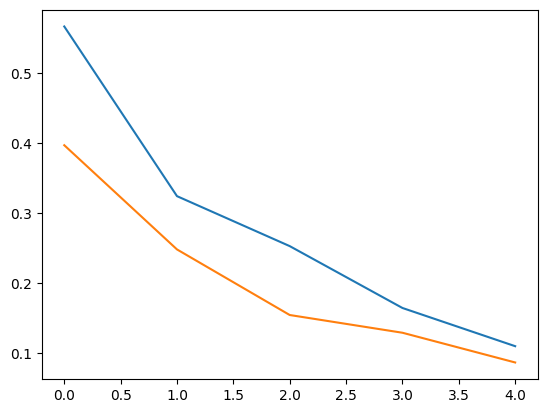

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
model1.save('modelpc.h5')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('modelpc.h5')

## Densenet

In [ ]:
from tensorflow.keras.applications import DenseNet201

In [ ]:
base_model = tf.keras.applications.DenseNet201(input_shape=(256,256,3),include_top=False,weights="imagenet")

74836368/74836368 [==============================] - 1s 0us/step


In [ ]:
# Freezing Layers

for layer in base_model.layers[:-5]:
    layer.trainable=False

In [ ]:
# Building Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D,RepeatVector

model=Sequential()
model.add(base_model)
model.add(Dropout(0.4))

model.add(Flatten())
model.add(RepeatVector(2))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))

In [ ]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 2, 1920)        18321984  
                                                                 
 dropout (Dropout)           (None, 2, 2, 1920)        0         
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 repeat_vector (RepeatVector  (None, 2, 7680)          0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 15360)             0         
                                                                 
 dense (Dense)               (None, 2)                 30722     
                                                        

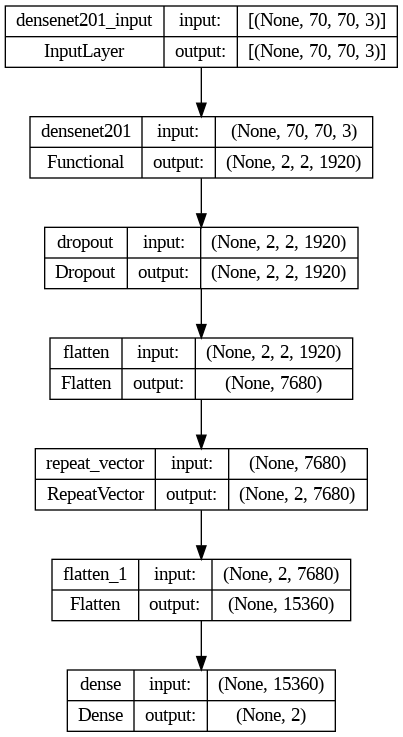

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.75, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=5)

In [ ]:
model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=METRICS)

In [ ]:
%time
history=model.fit(train_it,validation_data=(val_it),verbose = 1,epochs = 12,callbacks=[lrd,mcp,es])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
Epoch 1/12
86/86 [==============================] - 156s 1s/step - loss: 0.3832 - accuracy: 0.8688 - precision: 0.8688 - recall: 0.8688 - auc: 0.9348 - f1_score: 0.8688 - val_loss: 0.5814 - val_accuracy: 0.8541 - val_precision: 0.8541 - val_recall: 0.8541 - val_auc: 0.9017 - val_f1_score: 0.8541 - lr: 0.0010
Epoch 2/12
86/86 [==============================] - 100s 1s/step - loss: 0.3122 - accuracy: 0.8953 - precision: 0.8953 - recall: 0.8953 - auc: 0.9466 - f1_score: 0.8953 - val_loss: 0.4436 - val_accuracy: 0.8838 - val_precision: 0.8838 - val_recall: 0.8838 - val_auc: 0.9220 - val_f1_score: 0.8837 - lr: 0.0010
Epoch 3/12
86/86 [==============================] - 110s 1s/step - loss: 0.2545 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9605 - f1_score: 0.9037 - val_loss: 0.3260 - val_accuracy: 0.8914 - val_precision: 0.8914 - val_recall: 0.8914 - val_auc: 0.9453 - val_f1_score: 0.8913 - lr: 0.0010
Epoch 

## InceptionV3


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input


In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [ ]:
# Freezing Layers

for layer in base_model.layers[:-5]:
    layer.trainable=False

In [ ]:
# Building Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D,RepeatVector

model=Sequential()
model.add(base_model)
model.add(Dropout(0.4))

model.add(Flatten())
model.add(RepeatVector(2))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))

In [ ]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 repeat_vector (RepeatVector  (None, 2, 51200)         0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 102400)            0         
                                                                 
 dense (Dense)               (None, 2)                 204802    
                                                        

In [ ]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit( 
  train_it,
  validation_data=val_it,
  epochs=10)

Epoch 1/10
9/9 [==============================] - 208s 22s/step - loss: 2.2122 - accuracy: 0.8462 - val_loss: 0.7972 - val_accuracy: 0.9859
Epoch 2/10
9/9 [==============================] - 152s 17s/step - loss: 0.4659 - accuracy: 0.9915 - val_loss: 0.0333 - val_accuracy: 0.9887
Epoch 3/10
9/9 [==============================] - 191s 22s/step - loss: 0.1064 - accuracy: 0.9927 - val_loss: 0.0689 - val_accuracy: 0.9944
Epoch 4/10
9/9 [==============================] - 191s 22s/step - loss: 0.0788 - accuracy: 0.9952 - val_loss: 0.0669 - val_accuracy: 0.9944
Epoch 5/10
9/9 [==============================] - 191s 22s/step - loss: 0.0442 - accuracy: 0.9964 - val_loss: 0.0289 - val_accuracy: 0.9972
Epoch 6/10
9/9 [==============================] - 192s 23s/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0340 - val_accuracy: 1.0000
Epoch 7/10
9/9 [==============================] - 191s 22s/step - loss: 0.0079 - accuracy: 0.9988 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 8/10
9/9 [====

In [ ]:
model.save('/content/drive/MyDrive/pcos.h5')

Prediction

In [ ]:
from keras.preprocessing import image
import tensorflow as tf


def predictimage(path):
       
      img = tf.keras.utils.load_img(path,target_size=(224,224))
      i = tf.keras.utils.img_to_array(img)/255
      input_arr= np.array([i])
      input_arr.shape

      pred =model.predict(input_arr)
      if pred == 1:
          print("Not Affected")
      else :
         print("Affected")
      #display image
      plt.imshow(input_arr[0],vmin=0, vmax=255)
      plt.title("input Image")
      plt.show()

1/1 [==============================] - 1s 561ms/step
Affected


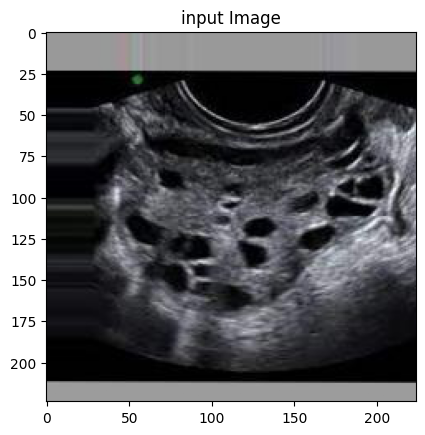

In [ ]:
predictimage("/content/drive/MyDrive/pcod/test/infected/img_0_1023.jpg") 

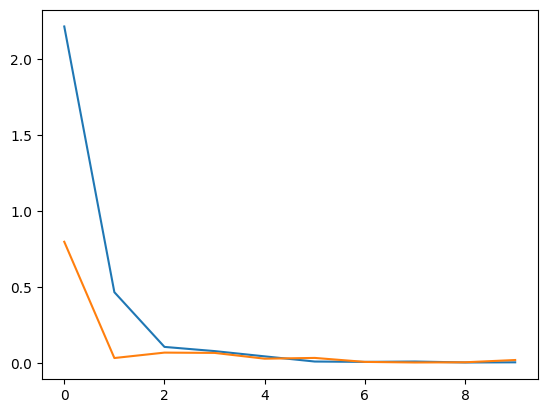

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])